In [158]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../Coding')
from itertools import combinations
from Algorithms import pattern_count
import time
from Algorithms import NewAlgRanking_19_20211216 as newalg
from Algorithms import NaiveAlgRanking_4_20211213 as naivealg
import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import NewAlgRanking_definition2_13_20220509 as newalg2
from Algorithms import NaiveAlgRanking_definition2_5_20220506 as naivealg2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['font.size'] = '22'

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 20
f_size = (18, 16)
FONTSIZE=50

In [159]:
def string2num(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                p.append(int(item))
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        p.append(int(item))
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        # output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
        return []
    else:
        # print(tuples_idx, len(tuples_idx))
        # for id in tuples_idx:
        #     print(id, shap_values.values[id])
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        # print(np.sum(shap_values.values[tuples_idx], axis=0))
        # output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        # output_file.write(str(avg))
        print("group {} size {}".format(group, len(tuples_idx)))
        # print(avg)
        return list(avg)


def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    if size_topk < Lowerbounds[0]:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True


def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    lowerbound = alpha * size_whole_data * k / len(data)
    print(size_whole_data, size_topk, lowerbound)
    if size_topk < lowerbound:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True

def plot_distribution_number(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    group_value_dis = [s[i] if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    whole_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    other_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i] if i in s else 0 for i in x_list]


    s = ranked_data[:k][attribute].value_counts().sort_index()
    topkdis = [s[i] if i in s else 0 for i in x_list]

    index = np.arange(len(x_list))
    bar_width = 0.2

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(index, x_list)

    plt.ylabel('number of tuples')
    plt.xlabel('value of attribute ' + attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()



In [160]:

def plot_distribution_ratio(ranked_data, attribute, original_att, group, group_name, k, axis):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    print(x_list)

    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]

    bar_width = 0.45
    index = np.arange(len(x_list))
    print(index)
    axis.bar(index, group_value_dis, bar_width, color=color[3], label=group_name)
    axis.bar(index + bar_width, topkdis, bar_width,  color=color[7], label="top-k")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    index2 = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
    axis.set_xticks([x + bar_width/2 for x in index2], [0, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=FONTSIZE)
    axis.set_yticks([0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3], fontsize=FONTSIZE)
    axis.set_ylabel('Ratio', fontsize=FONTSIZE)
    axis.set_xlabel('Value of '+ original_att, fontsize=FONTSIZE)
    axis.legend(loc='upper left', fontsize=45, bbox_to_anchor=(-0.02, 1.04))
    # plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    # plt.show()
    return axis


In [161]:

def plot_average_shap_value_of_group(data, group, selected_attributes, all_attributes_original, shap_values, axis):
    s = average_shapley_values_of_group(data, group, selected_attributes, shap_values)

    df=pd.DataFrame({'Attribute':all_attributes_original, 'Shapley values':s})
    df.sort_values(by='Shapley values',key=abs, inplace=True,ascending=False)

    small_shap_values = df[6:]
    summary_shap_values = df[:6]

    summary_shap_values = summary_shap_values.append({'Attribute': 'other positive Shapley values', 'Shapley values': sum([x if x > 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)
    summary_shap_values = summary_shap_values.append({'Attribute': 'other negative Shapley values', 'Shapley values': sum([x if x < 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)

    print(summary_shap_values)

    summary_shap_values = summary_shap_values[::-1]
    # summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], figsize=(18, 16), legend=False, fontsize=FONTSIZE, ax=axis)
    summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], legend=False, fontsize=FONTSIZE, ax=axis)
    axis.set_ylabel('Attribute', fontsize=FONTSIZE)
    # plt.show()
    # plt.xlabel('Shapley values', fontsize=FONTSIZE)
    # plt.ylabel('Attribute', fontsize=FONTSIZE)
    # plt.tight_layout()
    # fig.set(xlabel='Shapley values')
    # return plt



# student data

In [3]:

all_attributes = ['school_C', 'sex_C', 'age_C', 'address_C', 'famsize_C', 'Pstatus_C', 'Medu_C',
                  'Fedu_C', 'Mjob_C', 'Fjob_C', 'reason_C', 'guardian_C', 'traveltime_C', 'studytime_C',
                  'failures_C', 'schoolsup_C', 'famsup_C', 'paid_C', 'activities_C', 'nursery_C', 'higher_C',
                  'internet_C', 'romantic_C', 'famrel_C', 'freetime_C', 'goout_C', 'Dalc_C', 'Walc_C',
                  'health_C', 'absences_C', 'G1_C', 'G2_C', 'G3_C']


all_attributes_original = ['school', 'sex', 'age', 'address', 'family size', 'parent\'s cohabitation status', 'mother\'s education',
                  'father\'s education', 'mother\'s job', 'father\'s job', 'reason to choose this school', 'student\'s guardian', 'home to school travel time', 'weekly study time',
                  'number of past class failures', 'extra educational support', 'family educational support', 'extra paid classes', 'extra-curricular activities', 'attended nursery school', 'wants to take higher education',
                  'Internet access at home', 'with a romantic relationship', 'quality of family relationships', 'free time after school', 'going out with friends', 'workday alcohol consumption', 'weekend alcohol consumption',
                  'current health status', 'number of school absences', 'first period grade', 'second period grade', 'final grade']


original_data_file = r"../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)


# 16 att

In [4]:
selected_attributes = all_attributes[:16]

k = 49
k_min = k
k_max = k
thc = 50
Lowerbounds = [40]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


[-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 3, -1, 

In [5]:
selected_attributes = all_attributes[:16]

alpha = 0.8
k = 49
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 2.6047496795654297
finish kmin
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 0, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, 

In [6]:

x = ranked_data[all_attributes]
y = ranked_data['rank']
x.set_axis(all_attributes_original, axis=1, inplace=True)

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

school = 13.62283
sex = 3.74994
age = 21.58114
address = 9.59259
family size = -2.53632
parent's cohabitation status = 6.69229
mother's education = -3.16792
father's education = -1.79844
mother's job = -1.71096
father's job = -1.47305
reason to choose this school = -0.0908
student's guardian = 1.23539
home to school travel time = -1.59712
weekly study time = 0.46849
number of past class failures = -5.80891
extra educational support = -7.64857
family educational support = -3.48639
extra paid classes = 3.10652
extra-curricular activities = 4.29685
attended nursery school = -1.37875
wants to take higher education = 1.03296
Internet access at home = 0.54819
with a romantic relationship = -3.61323
quality of family relationships = -3.55531
free time after school = 0.22307
going out with friends = 4.11919
workday alcohol consumption = 1.28626
weekend alcohol consumption = -1.04685
current health status = 1.747
number of school absences = 22.40992
first period grade = -26

Permutation explainer: 396it [00:21, 12.94it/s]                         


.values =
array([[  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       ...,
       [  10.89826409,   -1.94996825,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   -1.51067972, ...,   14.13187482,
          35.21048952,  143.45144968]])

.base_values =
array([193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 19

group [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 59
                       Attribute  Shapley values
0                    final grade       33.497300
1            second period grade        8.048986
2             mother's education        5.924014
3             first period grade        5.260641
4  number of past class failures       -2.369837
5             father's education        1.946581
6  other positive Shapley values        6.872292
7  other negative Shapley values       -4.821745


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


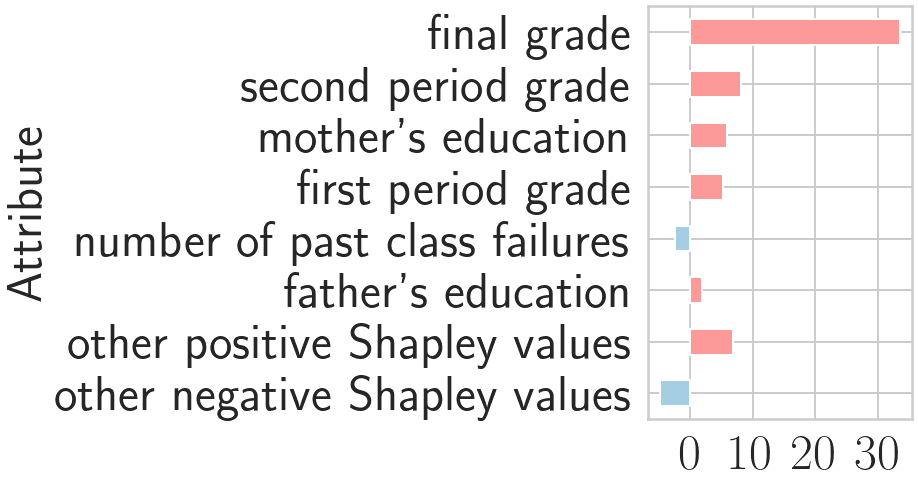

In [166]:
fig, ax = plt.subplots(1, 1,figsize=(14, 8))
group = groups_global_bounds[5]
plot_average_shap_value_of_group(ranked_data, group, selected_attributes, all_attributes_original, shap_values, ax)
plt.xticks([0, 10, 20, 30], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"student_shap_globalbounds.png")

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


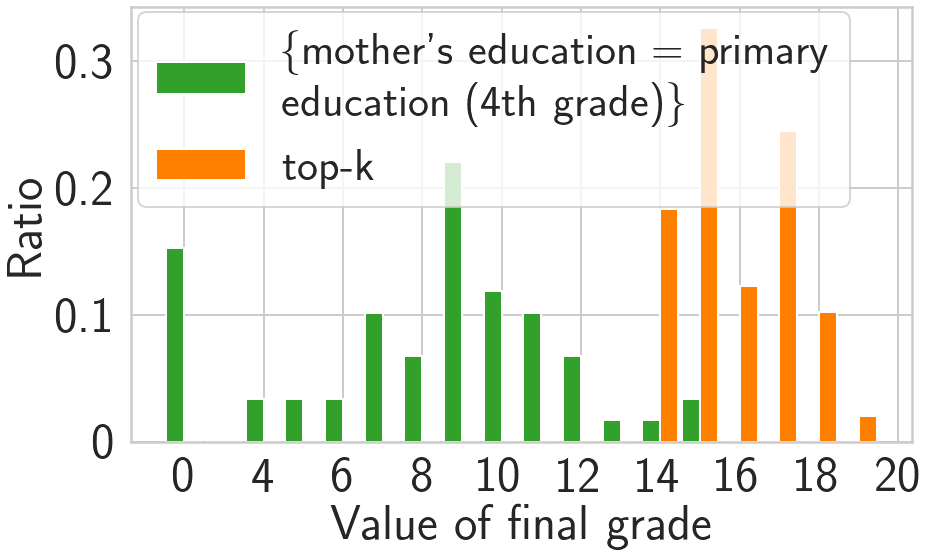

In [162]:
fig, ax = plt.subplots(1, 1,figsize=(14, 8))
original_att = 'final grade'
att = all_attributes[all_attributes_original.index(original_att)]
group_name = "\{mother's education = primary \neducation (4th grade)\}"
plot_distribution_ratio(ranked_data, 'G3', original_att, group, group_name, k, ax)
# plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize=FONTSIZE)
fig.show()
plt.savefig(r"student_value_dis_globalbounds.png", bbox_inches='tight')


# method 2

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
group [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 59
                       Attribute  Shapley values
0                    final grade       33.497300
1            second period grade        8.048986
2             mother's education        5.924014
3             first period grade        5.260641
4  number of past class failures       -2.369837
5             father's education        1.946581
6  other positive Shapley values        6.872292
7  other negative Shapley values       -4.821745


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


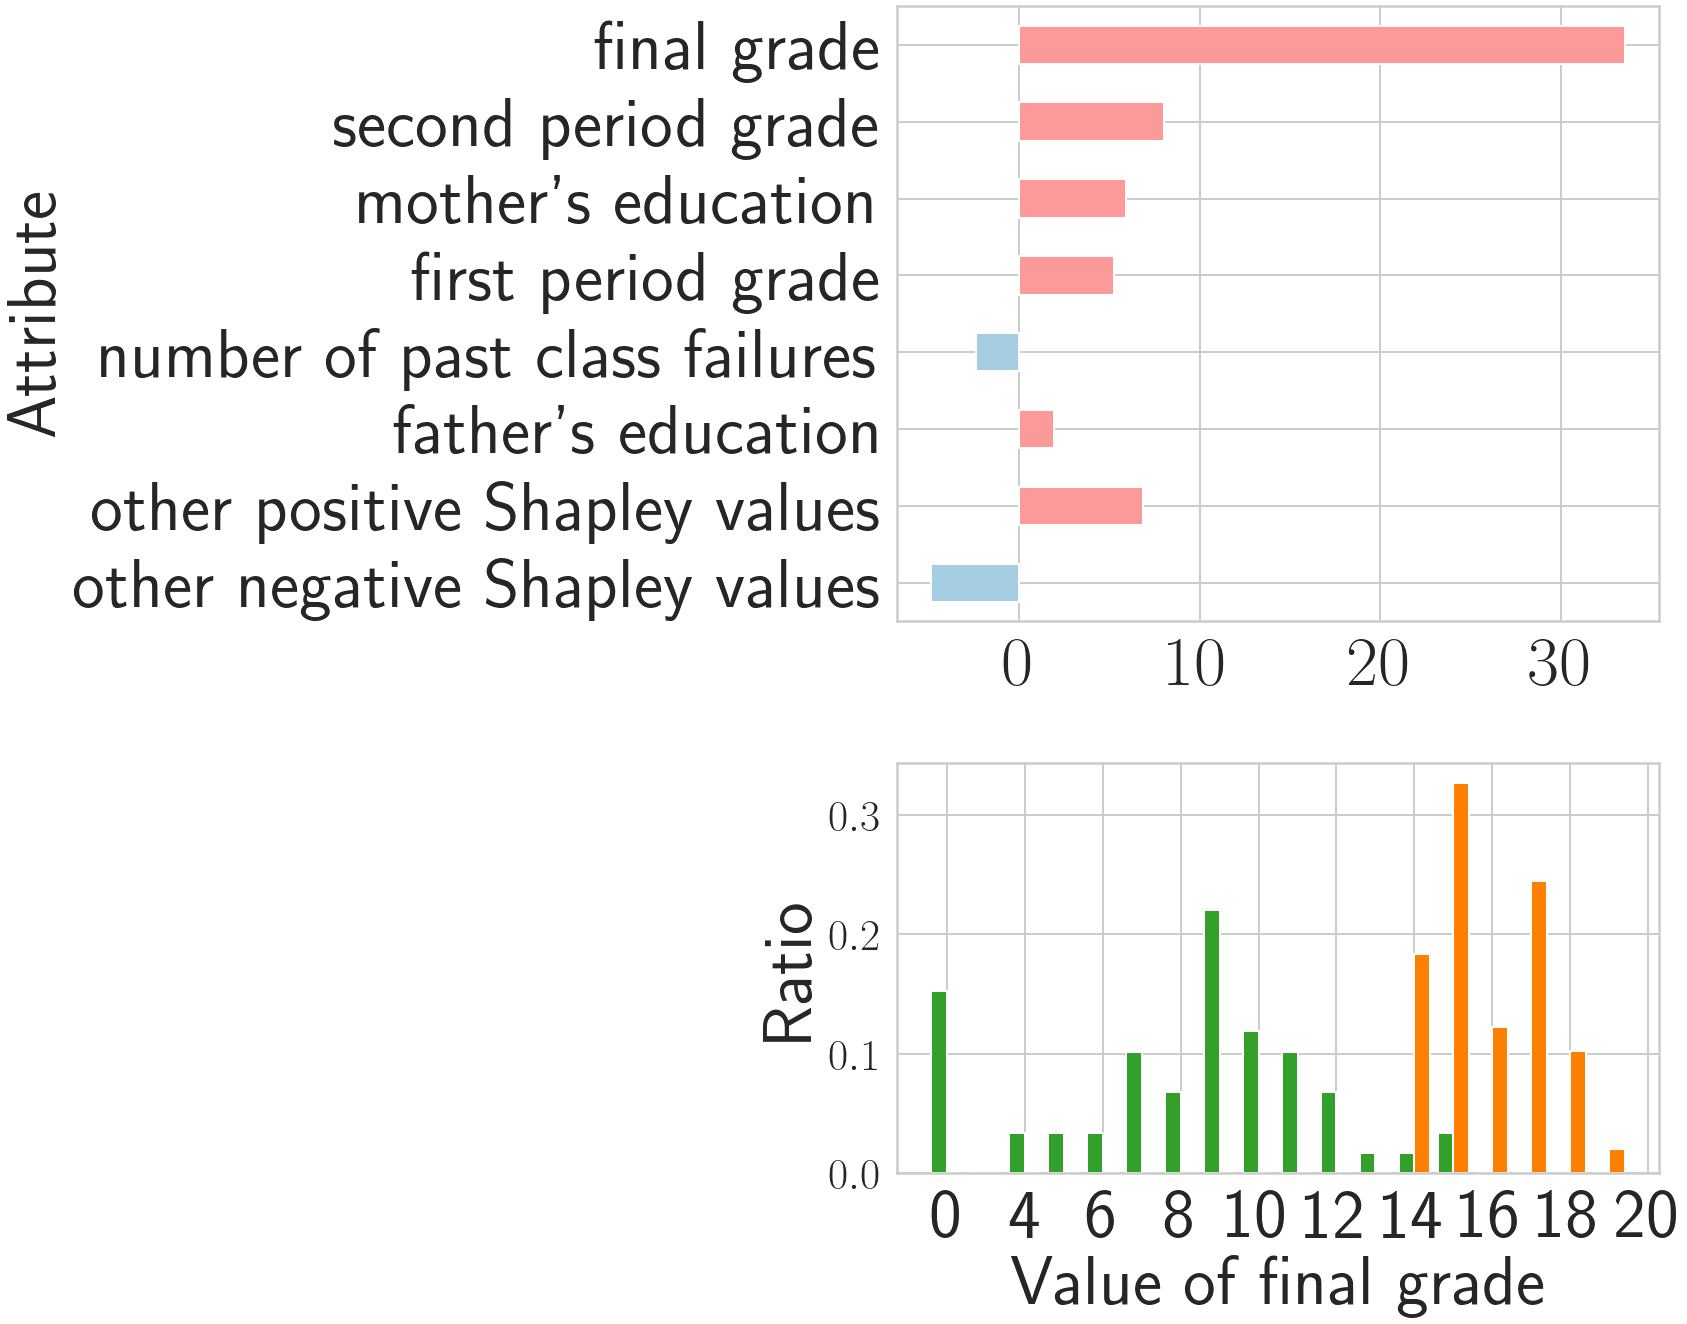

In [91]:
plt.rcParams.update({'font.size': 60})
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 20),gridspec_kw={'height_ratios': [3, 2]})
# f.subplots_adjust(wspace=0)


original_att = 'final grade'
att = all_attributes[all_attributes_original.index(original_att)]
group_name = "\{mother's education \n = primary education \n(4th grade)\}"
plt.sca(ax2)
plot_distribution_ratio(ranked_data, 'G3', original_att, group, group_name, k, ax2)

plt.sca(ax1)
group = groups_global_bounds[5]
plot_average_shap_value_of_group(ranked_data, group, selected_attributes, all_attributes_original, shap_values, ax1)
# plt.xticks([-5, 0, 10, 20, 30, 35], fontsize=FONTSIZE)
# plt.rcParams['font.size'] = '22'
# plt.savefig(r"student_shap_globalbounds.png")


# plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"student_shap_analysis.png", bbox_inches='tight')
plt.show()

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


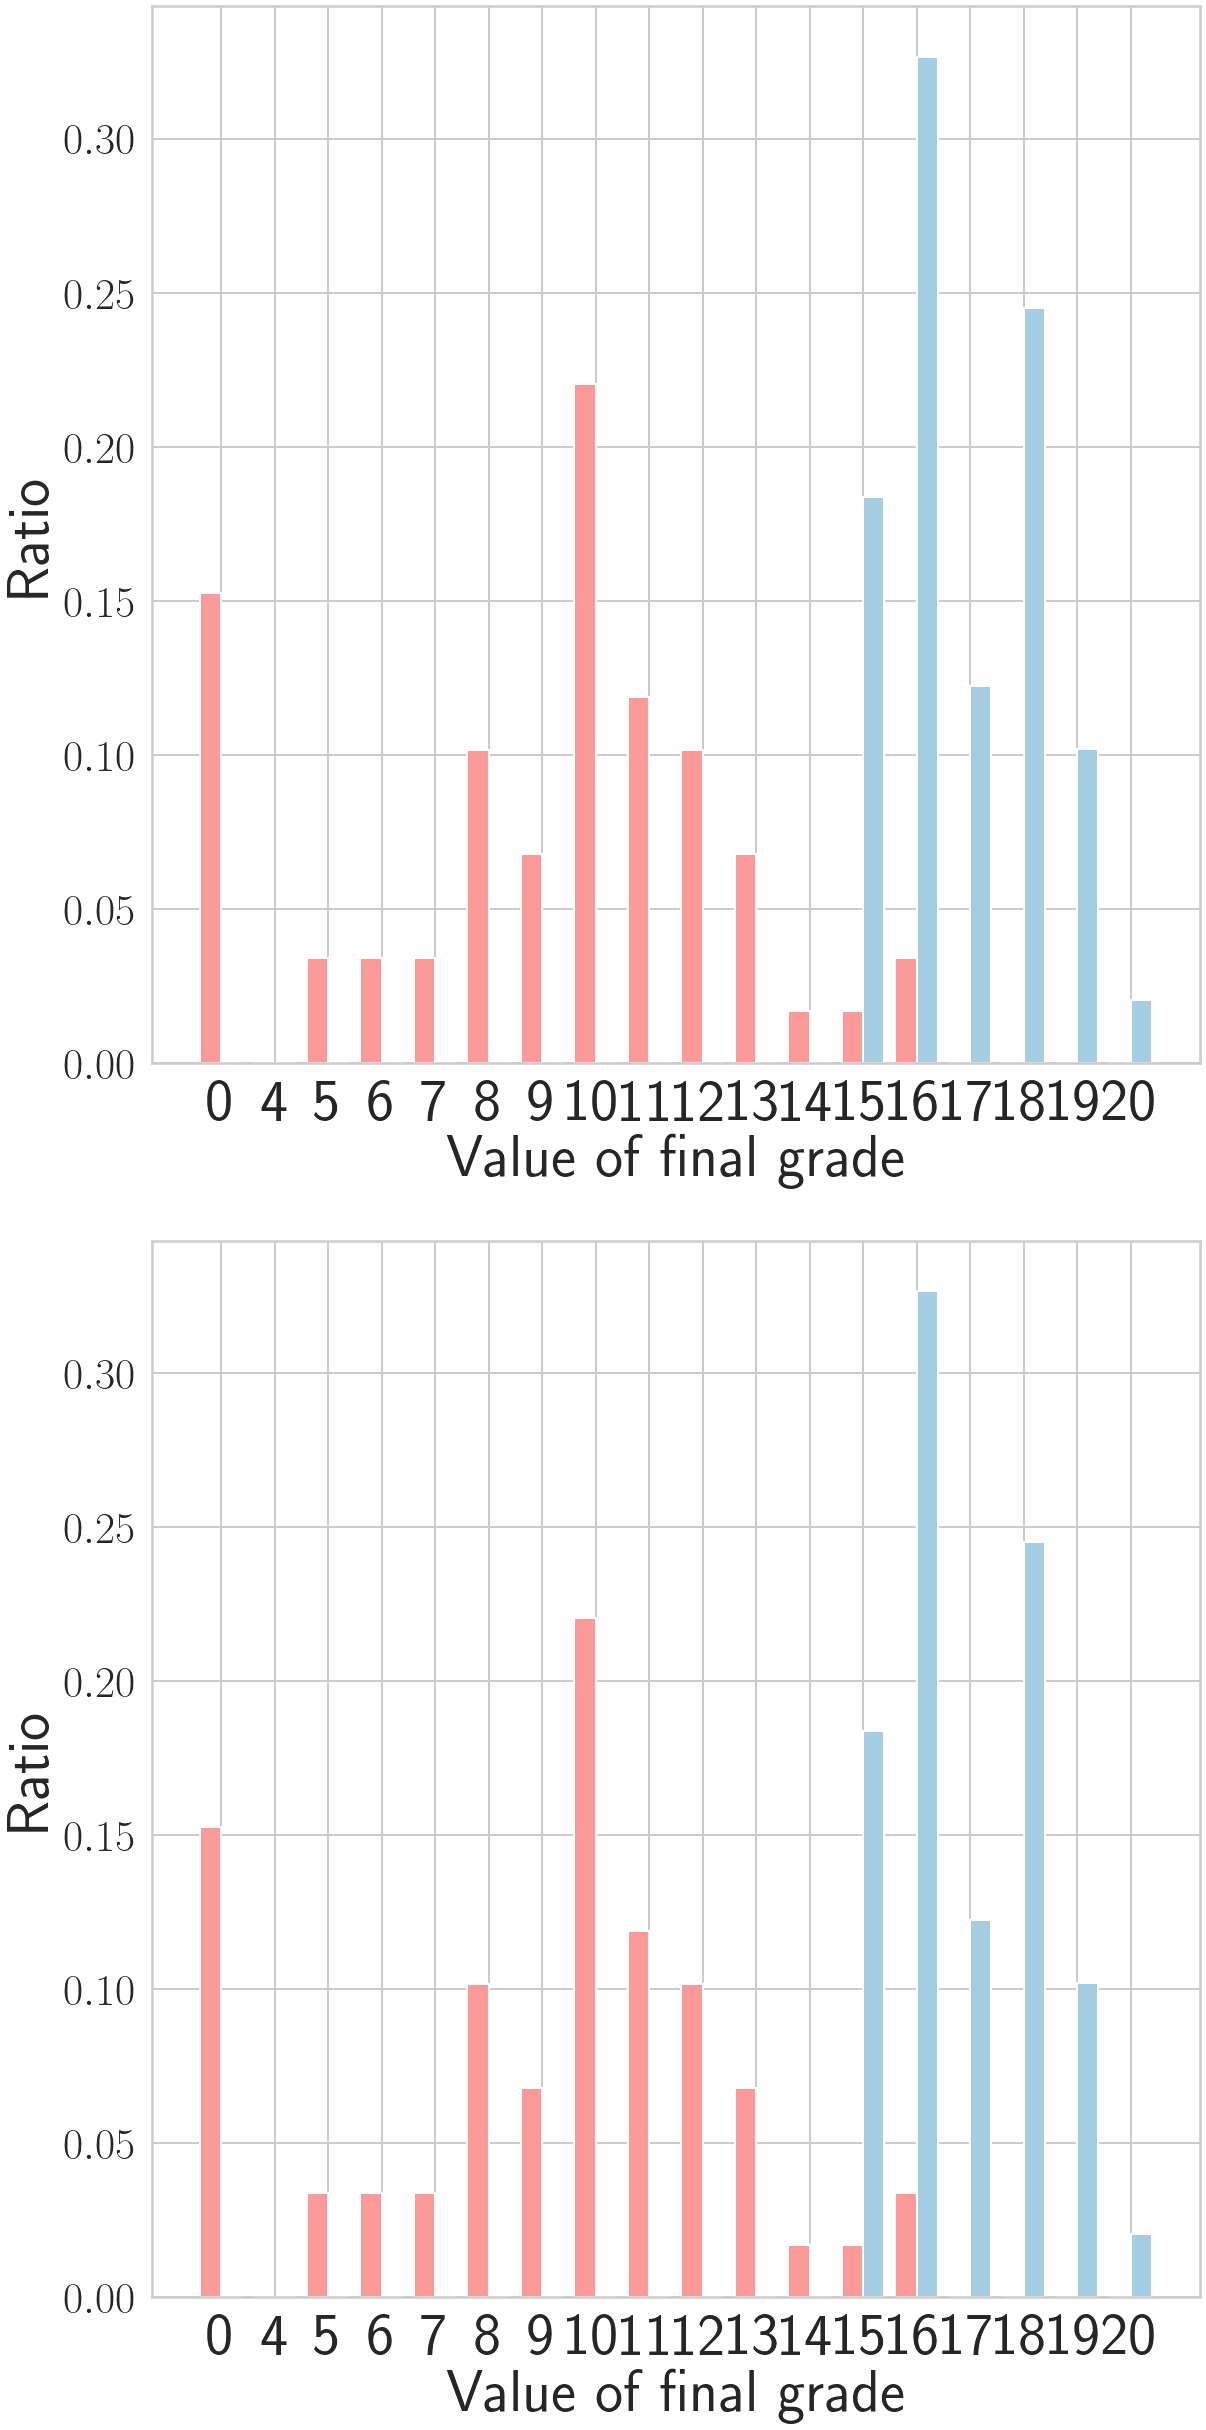

In [33]:

original_att = 'final grade'
att = all_attributes[all_attributes_original.index(original_att)]
group_name = "\{mother's education \n = primary education \n(4th grade)\}"

ax2 = fig.add_subplot(2, 1, 2)
plot_distribution_ratio(ranked_data, 'G3', original_att, group, group_name, k, ax2)

# plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize=FONTSIZE)
plt.tight_layout()
# plt.savefig(r"student_value_dis_globalbounds.png", bbox_inches='tight')
plt.show()


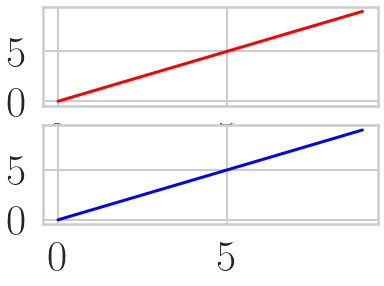

In [30]:

fig, ax = plt.subplots(2, 1)

ax[0].plot(range(10), 'r') #row=0, col=0
ax[1].plot(range(10), 'b') #row=1, col=0
